In [1]:
import torch
torch.cuda.set_device(4)
print(torch.cuda.current_device())

4


In [2]:
%run ../../prepare_data.py
%run ../../architectures.py

In [3]:
batch_size = 32

In [4]:
train_loader, valid_loader, valid_dataset = mura_dataloaders(batch_size)

In [5]:
x, y = next(iter(train_loader))

In [6]:
x.shape, y.shape

(torch.Size([32, 3, 250, 200]), torch.Size([32]))

In [7]:
model = resnet18().cuda()

In [8]:
sum(p.numel() for p in model.parameters())

11177025

CPU times: user 49.6 s, sys: 8.66 s, total: 58.3 s
Wall time: 58.6 s


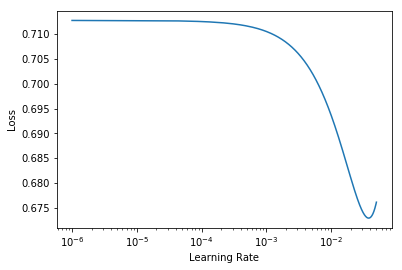

In [9]:
%%time
lrs, losses = LR_range_finder(model, train_loader, 
                              loss_fn=F.binary_cross_entropy_with_logits, 
                              binary=True, lr_high=0.05)
plot_lr(lrs, losses)

# Training

In [9]:
widths = [1.0, 0.75, 0.5, 0.25]
depths = [[[[64, 2], [128, 2]], [[256, 2], [512, 1]]],
          [[[64, 2], [128, 2]], [[256, 1], [512, 1]]],
          [[[64, 2], [128, 1]], [[256, 1], [512, 1]]],
          [[[64, 2], [128, 1]], [[256, 2], [512, 1]]],
          [[[64, 1], [128, 1]], [[256, 2], [512, 1]]],
          [[[64, 1], [128, 1]], [[256, 1], [512, 1]]],
         ]

In [ ]:
data = []

for w in widths:
    for d in depths:
        d_s = sum(j[1] for i in d for j in i)
        print('width multiplier - %.3f depth multiplier - %.3f' % (w, d_s))
        model = resnet18(width_mult=w, 
                         inverted_residual_setting1=d[0], 
                         inverted_residual_setting2=d[1]).cuda()
        
        p = sum(p.numel() for p in model.parameters())
        optimizer = create_optimizer(model, 0.02)
        score, t = train_triangular_policy(model, optimizer, train_loader, valid_loader, valid_dataset,
                                           loss_fn=F.binary_cross_entropy_with_logits, 
                                           dataset='mura', binary=True, max_lr=0.02, epochs=15)
        
        p = "/home/rimmanni/Medical_Images/Scaling_experiments/Mura/Resnet_" + str(w) + '_' + str(depths.index(d))
        save_model(model, p)
        data.append([w, d_s, score, p, t])
        print('')

width multiplier - 1.000 depth multiplier - 7.000
train_loss 0.679 val_loss 0.719 val_auc_score 0.536
----End of step 0:01:01.882114
train_loss 0.671 val_loss 0.700 val_auc_score 0.566
----End of step 0:01:01.392301
train_loss 0.667 val_loss 0.699 val_auc_score 0.620
----End of step 0:01:01.470825
train_loss 0.663 val_loss 0.699 val_auc_score 0.621
----End of step 0:01:01.839486
train_loss 0.654 val_loss 0.656 val_auc_score 0.677
----End of step 0:01:02.319210
train_loss 0.642 val_loss 0.657 val_auc_score 0.674
----End of step 0:01:02.612682
train_loss 0.632 val_loss 0.663 val_auc_score 0.707
----End of step 0:01:02.080421
train_loss 0.613 val_loss 0.636 val_auc_score 0.707
----End of step 0:01:02.044897
train_loss 0.594 val_loss 0.614 val_auc_score 0.762
----End of step 0:01:02.119300
train_loss 0.577 val_loss 0.633 val_auc_score 0.724
----End of step 0:01:02.187571
train_loss 0.561 val_loss 0.586 val_auc_score 0.796
----End of step 0:01:03.209421
train_loss 0.554 val_loss 0.594 val_a

In [ ]:
columns = ['width_x', 'depth_x', 'val_score', 'params', 'time_per_epoch']
df = pd.DataFrame(data=data, columns=columns)

In [ ]:
df.to_csv("mura_resnet_13.csv", index=False)

In [ ]:
df_re = pd.read_csv('mura_resnet_13.csv')

In [ ]:
df_re.head()